In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

In [ ]:
print(x.shape)
print(x.shape)
print(x[0].dtype)

(60000, 28, 28)
(60000, 28, 28)
uint8


In [ ]:
x = x.astype(np.float)
x_test = x_test.astype(np.float)
x /= 255
x_test /=255
print(x.max())
print(x.min())

<ipython-input-99-e2e56b88b339>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
<ipython-input-99-e2e56b88b339>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test.astype(np.float)


1.0
0.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape)
print(y_one_hot.shape)
print(y_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y_one_hot, test_size=0.2)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 28, 28)
(12000, 28, 28)
(48000, 10)
(12000, 10)


In [ ]:
class FC:
    """
    Fully connected layers from number of nodes n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in subsequent layers
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize.
        # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ

In [ ]:
class SimpleInitializerConv2d:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, F, C, FH, FW):
        """
        Initializing weights
        Parameters
        ----------
        
        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(F,C,FH,FW)
    
    def B(self, F):
        """
        Bias initialization
        Parameters
        ----------

        Returns
        ----------
        B : bias
        """
        return np.zeros(F)

In [ ]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

In [ ]:
class HeInitializer():
    """
    Initialization of weights by He
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

Optimization

In [ ]:
class SGD:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer

In [ ]:
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer

Activation function

In [ ]:
class ReLU():
    """
    Activation function : ReLU function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)

In [ ]:
class Softmax():
    """
    Activation Function : Softmax Function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ

Mini Batch

In [ ]:
# Mini-batch processing class
class GetMiniBatch:
    """
    Iterator to get the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      correct value
    batch_size : int
      Batch size
    seed : int
      Seeding random numbers in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

#Problem 1 - Creating 2D-Convolutional Layer

In [ ]:
# 2d convolutional layer class
class SimpleConv2d():
    """
    2-D convolutional layer
    Parameters
    ----------
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, F, C, FH, FW, P, S,
                 initializer=None,optimizer=None,activation=None):
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        
        # Initialize.
        # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(F,C,FH,FW)
        self.B = self.initializer.B(F)
        
    def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
        OH = (H +2*PH -FH)/SH +1
        OW = (W +2*PW -FW)/SW +1
        return int(OH),int(OW)
    
    def forward(self, X):
        """
        forward 
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        
        self.params = N,C,H,W,F,FH,FW,OH,OW

        A = np.zeros([N,F,OH,OW])

        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))

        # Batch
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(0,H,self.S):
                    # Horizontal Slide
                    for col in range(0,W,self.S):
                        A[n,ch,row,col] = \
                        np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]
                               *self.W[ch,:,:,:]) \
                        +self.B[ch]
        
        return  self.activation.forward(A)
    
    def backward(self, dZ):
        """
        backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        
        dA = self.activation.backward(dZ)
        N,C,H,W,F,FH,FW,OH,OW = self.params
        
        dZ = np.zeros(self.X_pad.shape)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        
        # dZ
        # Batch
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(0,H,self.S):
                    # Horizontal Slide
                    for col in range(0,W,self.S):
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
                
        dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
        dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)

        dZ = np.delete(dZ,dl_rows,axis=2)
        dZ = np.delete(dZ,dl_cols,axis=3)
                
        # dW
        # Batch
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(OH):
                    # Horizontal Slide
                    for col in range(OW):
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
        
        # dB
        # Output channels
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ

#Problem 2/3 - Experiments with 2D Conv. Layers & Output Size after 2DMC

In [ ]:
def output_shape2d(IH=5,IW=5,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1):
    OH = (IH +2*PH -FH)/SH +1
    OW = (IW +2*PW -FW)/SW +1
    return int(OH),int(OW)

In [ ]:
print(output_shape2d(IH=6,IW=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1))

(4, 4)


2DC Experiment

In [ ]:
N,C,H,W = (5,1,28,28)
F,C,FH,FW = (4,1,3,3)

S = 1 #Fixed for now
P = 1

OH,OW = output_shape2d(H,W,P,P,FH,FW,S,S)

A = np.zeros([N,F,OH,OW])

X_sample = x[0:N].reshape(N,C,H,W)
X_pad = np.pad(X_sample,((0,0),(0,0),(P,P),(P,P)))
w = np.ones([F,C,FH,FW])
B = np.ones(F)

# Forward

# Batch
for n in range(N):
    for ch in range(F):
        for row in range(0,H,S):
            for col in range(0,W,S):
                A[n,ch,row,col] = \
                np.sum(X_pad[n,:,row:row+FH,col:col+FW]*w[ch,:,:,:]) +B[ch]
                
print('A.shape:',A.shape)

A.shape: (5, 4, 28, 28)


In [ ]:
#Backward
dA = np.ones(A.shape)

dZ = np.zeros(X_pad.shape)
dW = np.zeros(w.shape)
dB = np.zeros(B.shape)

for n in range(N):
    for ch in range(F):
        for row in range(0,H,S):
            for col in range(0,W,S):
                dZ[n,:,row:row+FH,col:col+FW] +=dA[n,ch,row,col]*w[ch,:,:,:]

dl_rows = range(P),range(H+P,H+2*P,1)
dl_cols = range(P),range(W+P,W+2*P,1)

dZ = np.delete(dZ,dl_rows,axis=2)
dZ = np.delete(dZ,dl_cols,axis=3)

for n in range(N):
    for ch in range(F):
        for row in range(OH):
            for col in range(OW):
             dW[ch,:,:,:] +=dA[n,ch,row,col]*X_pad[n,:,row:row+FH,col:col+FW]

for ch in range(F):
    dB[ch] = np.sum(dA[:,ch,:,:])

print('dZ.shape:',dZ.shape)
print('dW.shape:',dW.shape)
print('dB.shape:',dB.shape)

dZ.shape: (5, 1, 28, 28)
dW.shape: (4, 1, 3, 3)
dB.shape: (4,)


Problem 4 - Creating a Maximum Pooling Layer

In [ ]:
class MaxPool2D():
    
    def __init__(self,P):
        self.P = P
        self.PA = None
        self.Pindex = None
        
    def forward(self,A):
        N,F,OH,OW = A.shape
        PS = self.P
        PH,PW = int(OH/PS),int(OW/PS)
        
        self.params = N,F,OH,OW,PS,PH,PW
        
        # Pooling filter
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        self.PA[n,ch,row,col] = \
                        np.max(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
                        self.Pindex[n,ch,row,col] = \
                        np.argmax(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self,dA):
        
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        idx = self.Pindex[n,ch,row,col]
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            else:
                                tmp[i] = 0
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        
        return dP

In [ ]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[1 8 0 3 1 8]
   [6 5 0 0 3 2]
   [2 4 0 6 2 4]
   [6 2 6 3 2 4]
   [2 1 1 0 7 5]
   [6 0 0 4 3 1]]]]


In [ ]:
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[8. 3. 8.]
   [6. 6. 4.]
   [6. 4. 7.]]]]


In [ ]:
Pooling.Pindex

array([[[[1., 1., 1.],
         [2., 1., 1.],
         [2., 3., 0.]]]])

In [ ]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[1 5 1]
   [8 1 5]
   [5 4 5]]]]


In [ ]:
dZ = Pooling.backward(dA)
print(dZ)

[[[[0. 1. 0. 5. 0. 1.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 1. 0. 5.]
   [8. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 5. 0.]
   [5. 0. 0. 4. 0. 0.]]]]


Problem 5 - Creating An Average Pooling

In [ ]:
class AveragePool2D():
    
    def __init__(self,P):
        self.P = P
        self.PA = None
        self.Pindex = None
        
    def forward(self,A):
        N,F,OH,OW = A.shape
        PS = self.P
        PH,PW = int(OH/PS),int(OW/PS)
        
        self.params = N,F,OH,OW,PS,PH,PW
        
        # Pooling filter
        self.PA = np.zeros([N,F,PH,PW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        self.PA[n,ch,row,col] = \
                        np.mean(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self,dA):
        
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            tmp[i] = dA[n,ch,row,col]/(PS*PS)

                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        
        return dP

In [ ]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[6 1 4 0 0 3]
   [7 2 1 1 1 6]
   [0 4 5 7 4 4]
   [4 7 1 5 1 5]
   [5 5 1 0 4 4]
   [3 0 7 5 8 6]]]]


In [ ]:
Pooling = AveragePool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[4.   1.5  2.5 ]
   [3.75 4.5  3.5 ]
   [3.25 3.25 5.5 ]]]]


In [ ]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[5 8 6]
   [6 3 2]
   [8 1 4]]]]


In [ ]:
dZ = Pooling.backward(dA)
print(dZ)

[[[[1.25 1.25 2.   2.   1.5  1.5 ]
   [1.25 1.25 2.   2.   1.5  1.5 ]
   [1.5  1.5  0.75 0.75 0.5  0.5 ]
   [1.5  1.5  0.75 0.75 0.5  0.5 ]
   [2.   2.   0.25 0.25 1.   1.  ]
   [2.   2.   0.25 0.25 1.   1.  ]]]]


#Problem 6 - Flatten

In [ ]:
class Flatten:
    def __init__(self,):
        pass
    def forward(self,X):
        self.shape = X.shape
        return X.reshape(len(X),-1)

    def backward(self,X):
        return X.reshape(self.shape)        

In [ ]:
TEST = np.zeros([20,2,5,5])
flt = Flatten()
flat_forward = flt.forward(TEST)
print('Forward_shape Display:', flat_forward.shape)
print('Backward_shape Display:',flt.backward(flat_forward).shape)

Forward_shape Display: (20, 50)
Backward_shape Display: (20, 2, 5, 5)


#Problem 7 - Training and Estimation

In [ ]:
# Scratch CNN
class Scratch2dCNNClassifier():
    """
    N-Layer Convolutional Neural Network Classifier
    
    Parameters
    ----------
    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        # Parameters
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN
        self.CNN = CNN
        
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)
                
    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                                
                # Forward propagation
                forward_data = mini_X_train[:,np.newaxis,:,:]
                
                # Conv
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                
                # Flatten
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                
                # NN
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                    
                # Predicted value
                Z = forward_data
                
                # Back propagation
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                   
                    
                backward_data = flt.backward(backward_data)
                
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)
                
                # Loss function
                self.loss += self.loss_function(Z,mini_y_train)
                
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """
        Estimate using a neural network classifier.。

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following, shape (n_samples, 1)
            Estimation results
        """
        pred_data = X[:,np.newaxis,:,:]
        
        # Conv
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
                
        pred_data = flt.forward(pred_data)
        
        # NN
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
            
        return np.argmax(pred_data,axis=1)

In [ ]:
NN = {0:FC(7840, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
      1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
      2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
     }

In [ ]:
CNN = {0:SimpleConv2d(F=10, C=1, FH=3, FW=3, P=1, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU())}

In [ ]:
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=200,verbose=False)

cnn1.fit(x_train[0:1000],y_train[0:1000])

<ipython-input-110-be33727ef1fa>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
<ipython-input-110-be33727ef1fa>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

In [ ]:
y_pred = cnn1.predict(x_valid[0:100])

accuracy = accuracy_score(np.argmax(y_valid[0:100],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.800


Visualizing the Loss Function

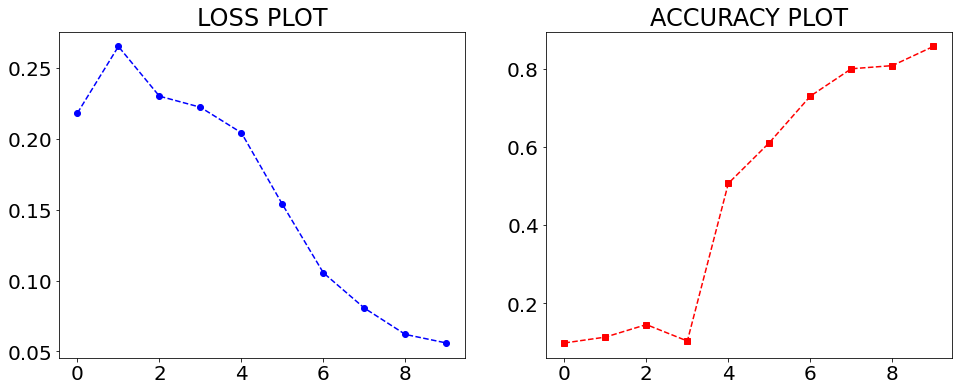

In [ ]:
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS PLOT')
plt.plot(cnn1.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACCURACY PLOT')
plt.plot(cnn1.log_acc,'rs--');

#Problem 8 - LeNet

In [ ]:
LeNetCNN = {0:SimpleConv2d(F=6, C=1, FH=5, FW=5, P=2, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
            1:MaxPool2D(P=2),
            2:SimpleConv2d(F=16, C=6, FH=5, FW=5, P=2, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
            3:MaxPool2D(P=2),}

LeNetNN = {0:FC(784, 120, HeInitializer(), AdaGrad(0.01), ReLU()),
            1:FC(120, 84, HeInitializer(), AdaGrad(0.01), ReLU()),
            2:FC(84, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),}


LeNet = Scratch2dCNNClassifier(NN=LeNetNN,CNN=LeNetCNN,
                               n_epoch=10,n_batch=20,verbose=False)

LeNet.fit(x_train[0:1000],y_train[0:1000])     

<ipython-input-110-be33727ef1fa>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
<ipython-input-110-be33727ef1fa>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

In [ ]:
y_pred_LeNet = LeNet.predict(x_valid[0:100])

accuracy = accuracy_score(np.argmax(y_valid[0:1000],axis=1), y_pred_LeNet)
print('accuracy:{:.3f}'.format(accuracy))

In [ ]:
import matplotlib as plt

plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS PLOT')
plt.plot(LeNet.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACCURACY PLOT')
plt.plot(LeNet.log_acc,'rs--');

#Problem 9 - Survey of Well-Known image recognition models 

In [ ]:
#Introduction
#The human brain can easily recognize and distinguish the objects in an image. For instance, given the image of a cat and dog, within nanoseconds, we distinguish the two and our brain perceives this difference. In case a machine mimics this behavior, it is as close to Artificial Intelligence we can get. Subsequently, the field of Computer Vision aims to mimic the human vision system – and there have been numerous milestones that have broken the barriers in this regard.
"The rapid developments in Computer Vision, and by extension – image classification has been further accelerated by the advent of Transfer Learning. To put it simply, Transfer learning allows us to use a pre-existing model, trained on a huge dataset, for our own tasks. Consequently, reducing the cost of training new deep learning models and since the datasets have been vetted, we can be assured of the quality.In Image Classification, there are some very popular datasets that are used across research, industry, and hackathons. The following are some of the prominent ones:"
•	ImageNet
•	CIFAR
•	MNIST


##Pre-Trained Models for Image Classification 
•	VGG-16
•	Inceptionv3
•	ResNet50
•	EfficientNet

#1. Very Deep Convolutional Networks for Large-Scale Image Recognition (VGG-16)
"The VGG-16 is one of the most popular pre-trained models for image classification. Introduced in the famous ILSVRC 2014 Conference, it was and remains THE model to beat even today. Developed at the Visual Graphics Group at the University of Oxford, VGG-16 beat the then standard of AlexNet and was quickly adopted by researchers and the industry for their image Classification Tasks."

#2. Inceptionv3
"While researching for this article – one thing was clear. The year 2014 has been iconic in terms of the development of really popular pre-trained models for Image Classification. While the above VGG-16 secured the 2nd rank in that years’ ILSVRC, the 1st rank was secured by none other than Google – via its model GoogLeNet or Inception as it is now later called as.The original paper proposed the Inceptionv1 Model. At only 7 million parameters, it was much smaller than the then prevalent models like VGG and AlexNet. Adding to it a lower error rate, you can see why it was a breakthrough model. Not only this, but the major innovation in this paper was also another breakthrough – the Inception Module.""

#3. ResNet50
"Just like Inceptionv3, ResNet50 is not the first model coming from the ResNet family. The original model was called the Residual net or ResNet and was another milestone in the CV domain back in 2015.The main motivation behind this model was to avoid poor accuracy as the model went on to become deeper. Additionally, if you are familiar with Gradient Descent, you would have come across the Vanishing Gradient issue – the ResNet model aimed to tackle this issue as well. Here is the architecture of the earliest variant: ResNet34(ResNet50 also follows a similar technique with just more layers)"

#4. EfficientNet
"We finally come to the latest model amongst these 4 that have caused waves in this domain and of course, it is from Google. In EfficientNet, the authors propose a new Scaling method called Compound Scaling. The long and short of it is this: The earlier models like ResNet follow the conventional approach of scaling the dimensions arbitrarily and by adding up more and more layers.However, the paper proposes that if we scale the dimensions by a fixed amount at the same time and do so uniformly, we achieve much better performance. The scaling coefficients can be in fact decided by the user.Though this scaling technique can be used for any CNN-based model, the authors started off with their own baseline model called EfficientNetB0:""

##https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/



#Problem 11 - Survey on Filter Size

1. why are 3*3 filters commonly used instead of larger ones such as 7**7?
- Using a 3x3 filter expresses most information about the image across all the channels while keeping the size of the convolutions layers consistent with the size of the image (zero padding allows us to achieve this).



2. What is the effect of a 1*1 filter with no height or width direction?
- A 1 x 1 Convolution is a convolution with some special properties in that it can be used for dimensionality reduction, efficient low dimensional embeddings, and applying non-linearity after convolutions. It maps an input pixel with all its channels to an output pixel which can be squeezed to a desired output depth.